# Modelo: Boosting

El modelo a entrenar en el siguiente notebook será un ensamble. En particular buscaremos hacer un **Boosting**. Boosting es un ensamble de tipo homogéneo que consiste en entrenar diferentes instancias con un modelo de forma iterativa.

La particularidad de Boosting se da en como se realiza ese entrenamiento. En primer lugar, se entrena un modelo como lo veniamos haciendo hasta ahora. A continuación, a las instancias en las que el primer modelo falló se les asigna un peso mayor para realizar el entrenamiento del segundo modelo. Es decir, un indicativo para comunicarle al segundo modelo en que instancias se equivocó el primer modelo, las mal clasificadas. En definitiva Boosting, tendras distintos modelos donde cada uno proriza los mal clasificados del anterior modelo.

De esta manera se continua de forma iterativa hasta obtener un score deseado. El sesgo y la varianza, ya que en cada estimador se ven los datos de forma diferente por el peso asignado.

A la hora de evaluar instancias, el modelo realiza una votación ponderada (según que tan bien fue la performance de ese modelo durante el entrenamiento) entre todos sus estimadores y arroja una predicción.

Para implementar este ensamble utilizaremos **GradientBoostingClassifier** de la libreria sklearn. Esta implementación utiliza árboles de decisión como algoritmo base. Además, utiliza una función de perdida para calcular el error en las predicciones arrojadas por cada árbol y a partir de ella optimiza los parámetros de los siguientes árboles mediante descenso por gradiente.

## Librerias y funciones necesarias

Comenzamos importando las librerias y funciones que serán necesarias para preprocesar nuestros datos, realizar nuestro entrenamiento y obtener metricas 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada
from preprocessing import get_dataframe_scaled
from preprocessing import reduccion_rfecv
from preprocessing import get_dataframe_polynomial

## Primer preprocesamiento

En primer lugar obtenemos el dataset para entrenar y el holdout. En segundo lugar, aplicamos una función que trabaja sobre las features, generalizando algunas y dejando de lado otras según lo observado en la primer parte de este trabajo práctico. También separamos a la variable target del resto del dataset. Por último, convertimos a númericas las variables categoricas para poder entrenar nuestro modelo

In [3]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

### Entrenamiento

Vamos a realizar un entrenamiento con 5 folds. Para ello utilizaremos StratifiedKFold para asegurarnos de obtener folds balanceados. 

En cuanto a la busqueda de hiperparámetros, vamos a buscar distitnas variaciones de altura de los árboles y mínimas instancias por hoja tal y como realizamos en el modelo de árbol de decisión. 

También, buscaremos el hiperparámetro *n_estimators*, el cual define la cantidad de modelos que se usarán uno al otro en la cadena de boosting. En nuestro caso seria *n* arboles usados. Si este número fuese muy grande, el modelo podria estar overfitteando. Aún así, según su propia documentación, **GradientBoostingClassifier** es un modelo muy robusto al overfitting por lo que deberia arrojar mejores resultados con más estimadores. 

Otro hiperparámetro importante será el *learning rate*, el cual determinará cuanto contribuye cada árbol con el siguiente en la función de perdida utilizada. En este caso tomaremos el default

In [5]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),
          "min_samples_leaf":np.arange(50,150,20),
          "n_estimators":np.arange(50,350,50)}
          #"learning_rate":np.arange(0.1,0.9,0.1)}
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose = True)


Ahora sí, entrenamos nuestro modelo

In [6]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 43.7min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f519d39bb30>,
             estimator=GradientBoostingClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 50,  70,  90, 110, 130]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='roc_auc', verbose=True)

Algo que resulta interesante observar es que valor se tiene en la función de pérdida (Deviance) en cada iteración. Graficamos 

Text(0, 0.5, 'Perdida')

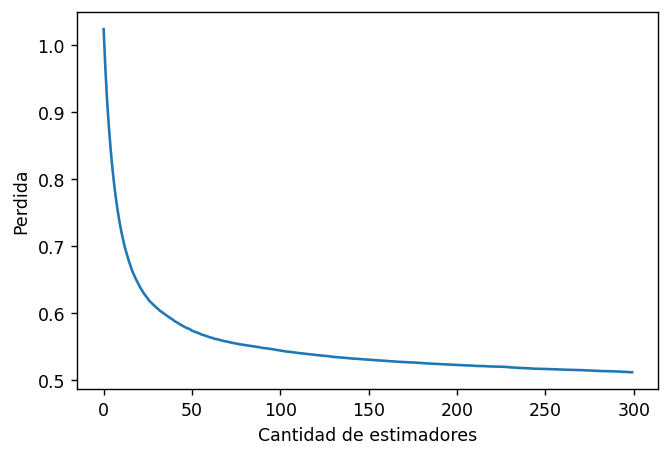

In [7]:
best = clf.best_estimator_
score_estimadores = best.train_score_
plt.figure(dpi=125)
plt.plot(score_estimadores)
plt.xlabel("Cantidad de estimadores")
plt.ylabel("Deviance")

Lo que se observa es que a partir de cierto numero de estimadores, la pérdida se reduce muy lentamente y comienza a comportarse de forma asintótica. Por lo que aumentar más el número de estimadores generaria poca ganancia. 

Realizamos nuestras predicciones para una análisis más amplio

In [8]:
y_pred = clf.predict(X_test)

### Metricas

AUC-ROC score sobre test:  0.9292791497286477
AUC-ROC score sobre train:  0.9407463366669064
Accuracy sobre test:  0.8713342545677875
Accuracy sobre train:  0.8812960687960688
              precision    recall  f1-score   support

  Bajo valor       0.89      0.94      0.92      4945
  Alto valor       0.78      0.65      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513

Los mejores hiperpametros elegidos:  {'max_depth': 5, 'min_samples_leaf': 70, 'n_estimators': 300}


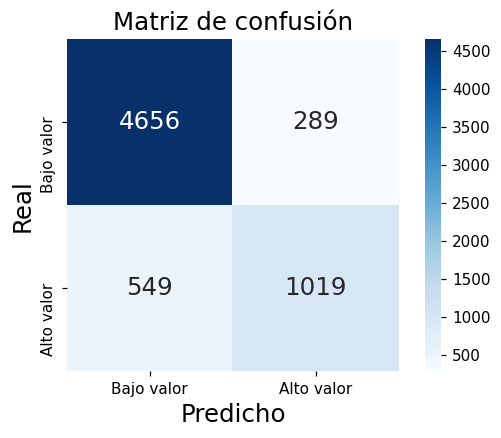

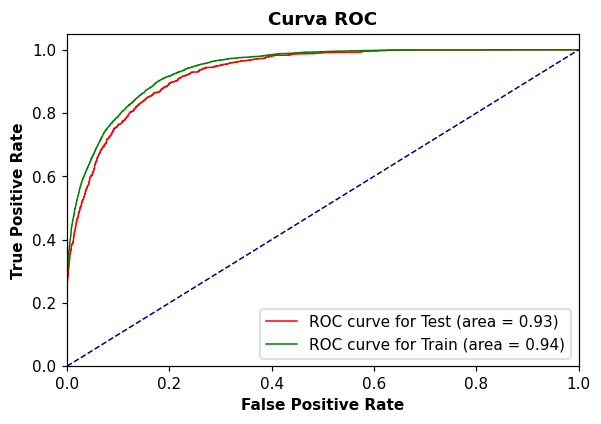

In [9]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf.predict(X_train), y_train))
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train) # 9296

Obtenemos buenas métricas a nivel general y además la brecha entre el test y el train parece ser lógica por lo que entendemos no estariamos overfitteado. Probemos igualmente otro preprocesamiento para ver si obtenemos algo diferente

## Segundo preprocesamiento

Realizamos nuesttro nuevo preprocesado. En este caso se trata de una modificación mas leve a nuestras features en donde no agruparemos como lo hicimos en el primer preprocesado (por ejemplo en la educación). Además, tendremos en cuenta a la feature barrio, generalizando entre los residente en Palermo y los no residentes en Palermo. 

In [10]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df)
X_df = conversion_numerica_generalizada(X_df)


Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


También, utilizaremos el algoritmo de RFECV para que seleccione solo las features que resultan más importantes al entrenar con un único árbol de decisión, tomando los hiperparámetros que habiamos encontrado como óptimos en el modelo *Árbol de decisión*

Creemos que ésto podria llegar a favorecer a gradient boosting para que solo entrene con features que fueron útiles a partir de un primer árbol de decisión, aunque también podríamos perder información necesaria y por lo tanto más score porque esto termina tratándose de un **método de reducción de dimensionalidad**. Esto podria terminar siendo una posible ventaja a la hora de entrenar ya que seguramente bajaria el tiempo

Otro punto a destacar es que el sesgo del modelo podría aumentar al ver solo features importantes de un único y primer árbol solo y podira aprovecharse la idea de éste modelo de ensamble 'boosting' donde un estimador le dice a otro en cual instancias se equivocó asignándoles un peso, dado que estaríamos quitándole features a estas instancias mal clasificadas el cual un estimador podría aprovechar clasificar mejor.

Veamos más detalle de qué hace el algoritmo RFECV:

In [11]:
reduccion_rfecv

<function preprocessing.reduccion_rfecv(clf, X_df, Y_df, min_features_to_select=1, n_jobs=-1, scoring='roc_auc', cv=5)>

In [12]:
reduccion_rfecv?

Signature:
reduccion_rfecv(
    clf,
    X_df,
    Y_df,
    min_features_to_select=1,
    n_jobs=-1,
    scoring='roc_auc',
    cv=5,
)
Docstring:
Es una técnica de selección de tipo embedded, encargándose de rankear variables según métodos internos de cada algoritmo.

La idea principal de RFECV es igual a la del RFE. Es decir:

1. Entrenar un modelo con un clasificador recibido ('clf')
2. Obtener importancias a partir de un modelo.  
3. Eliminar la/las variables menos importantes
4. Repetir 

Esto se repite hasta que converga y mi modelo deje de mejorar. Un hiperparámetro importante de la implementación RFE 
en sklearn es la **cantidad de features a seleccionar** pero ese numero no suele conocerse.

Para buscar el numero de optimo de features a seleccionar, el método de RFECV utiliza cross-validation (por eso el acrónimo RFECV: RFE-CV).
Es decir, realiza la validación (sobre el conjunto validación 'Y_df' recibido aplicándole el clasificador 'clf') con cross-validation usando
diferent

Aplicamos RFECV

In [13]:
clf_2 = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf = 500)
X_reducido = reduccion_rfecv(
    clf = clf_2,
    X_df = X_df,
    Y_df = y_df,
    min_features_to_select=20)

In [14]:
X_reducido

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
0,17,39,13,2174,40,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,17,50,13,0,13,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,13,38,8,0,40,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,11,53,6,0,40,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,17,28,13,0,40,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,27,12,0,38,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
32557,13,40,8,0,40,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
32558,13,58,8,0,40,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32559,13,22,8,0,20,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


Realizamos nuevamente el split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_reducido, y_df, random_state=10, test_size=0.20, stratify=y_df)

### Entrenamiento

Volvemos a realizar un entrenamiento con 5 folds, utilizando las mismas librerias y funciones utilizadas anteriormente

In [16]:
cv = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_2 = GradientBoostingClassifier(random_state=10)
params = {"max_depth":np.arange(3,8),"min_samples_leaf":np.arange(50,150,20),"n_estimators":np.arange(50,350,50)}
clf_2 = GridSearchCV(clf_2, params, scoring='roc_auc', cv=cv, n_jobs = -1)


Entrenamos nuestro modelo

In [17]:
clf_2.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f51b1df8e40>,
             estimator=GradientBoostingClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([ 50,  70,  90, 110, 130]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='roc_auc')

De nuevo, graficamos pérdida en función de estimadores

Text(0, 0.5, 'Perdida')

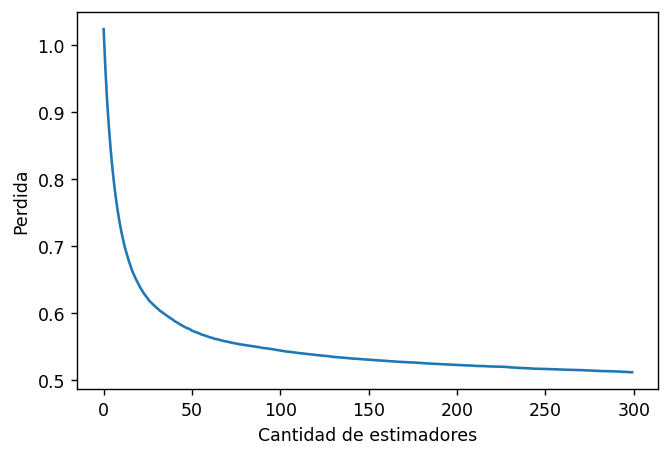

In [7]:
best = clf_2.best_estimator_
score_estimadores = best.train_score_
plt.figure(dpi=125)
plt.plot(score_estimadores)
plt.xlabel("Cantidad de estimadores")
plt.ylabel("Deviance")

Y observamos un comportamiento similar al caso anterior

Realizamos nuestras predicciones para una análisis más amplio

In [18]:
y_pred = clf_2.predict(X_test)

### Metricas

AUC-ROC score sobre test:  0.9220030024143127
AUC-ROC score sobre train:  0.9301482100862505
Accuracy sobre test:  0.8661139259941655
Accuracy sobre train:  0.8713528869778869
              precision    recall  f1-score   support

  Bajo valor       0.89      0.94      0.91      4945
  Alto valor       0.76      0.65      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513

Los mejores hiperpametros elegidos:  {'max_depth': 4, 'min_samples_leaf': 50, 'n_estimators': 300}


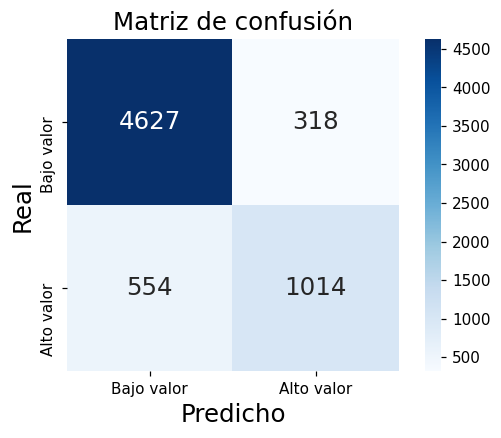

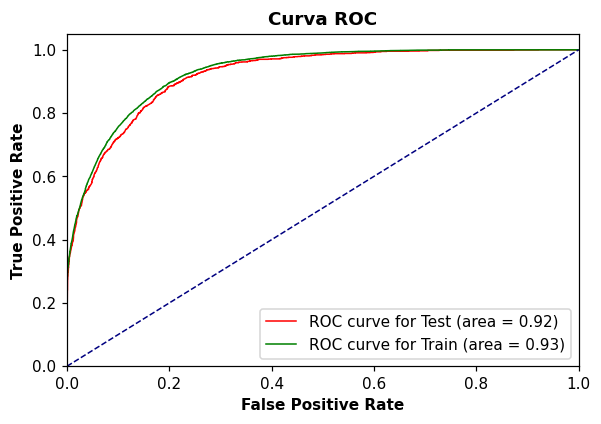

In [19]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Accuracy sobre train: ", "%0.16f"  % accuracy_score(clf_2.predict(X_train), y_train))
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
print("Los mejores hiperpametros elegidos: ", clf_2.best_params_)
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_2, X_test, y_test, X_train, y_train)

Se redujo la brecha entre el test y train y además mejoro levemente el recall para la clase de altos ingresos. Para finalizar pasamos a testear en el holdout

## Holdouts

Realizamos los testeos requeridos en el holdout. Como el primer preprocesamiento dio levemente mejor la métrica AUC-ROC para el test, utilizamos el primer modelo

In [20]:
from preprocessing import aplicar_preparacion_holdout
X_holdout = aplicar_preparacion_holdout(df_for_prediction, generalizada=False)

Apliquemos el procesado con el que obtuvimos el mejor score AUC-ROC:

In [21]:
X_holdout_numerico = conversion_numerica(X_holdout) 

Aplicando 'conversion_numerica' en las variables categóricas.


Hagamos **.predict()** sobre este holdout para luego agregarlo como nueva columna en este dataset para así exportar el **.csv** con facilidad mediante Pandas. 

In [22]:
y_pred_holdout = clf.predict(X_holdout_numerico)
X_holdout['tiene_alto_valor_adquisitivo'] = y_pred_holdout

In [23]:
name_model = '#6 - Boosting'

if X_holdout.index[0] == 0:
    X_holdout.index += 1 
X_holdout['tiene_alto_valor_adquisitivo'].to_csv('predicciones/' + name_model + '.csv', index=True, index_label = 'id')